In [50]:
import cv2
import numpy as np
from pathlib import Path
import json
import torch
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [179]:
class LaneDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir = 'archive/TUSimple/train_set', imagesize = (512,256), train=True):
        self._data_dir = data_dir
        self._mode = 'train' if train else 'eval'
        self._image_size = imagesize

        if self._mode == 'train':
            label_files = [os.path.join(self._data_dir, f'label_data_{suffix}.json') for suffix in ("0313","0531")]
        elif self._mode == 'eval':
            label_files = [os.path.join(self._data_dir, f'label_data_{suffix}.json') for suffix in ("0601",)]

        self._data = []
        for label_file in label_files:
            self._preprocess_labels(label_file)

    def __len__(self):
        return len(self._data)
    
    def __getitem__(self, idx):
         image_path = os.path.join(self._data_dir ,self._data[idx][0])
         image = cv2.imread(image_path)
         h,w,c = image.shape

         raw_image = image
         image = cv2.resize(image, self._image_size, interpolation= cv2.INTER_LINEAR)
         image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
         image = image[..., None]
         lanes = self._data[idx][1]

         new_image = self._draw_lines(lanes, h, w)

         image = torch.from_numpy(image).float().permute(2,0,1)
         new_image = torch.from_numpy(new_image.copy())
         new_image = new_image.to(torch.int64)

         return raw_image, new_image
    
    def _draw_lines(self, lanes, h, w):
        blank_image = np.zeros((h,w),"uint8")
        for i, lane in enumerate(lanes):
            cv2.polylines(blank_image, [lane],False,color=1, thickness=5)
        image = cv2.resize(blank_image, self._image_size, interpolation= cv2.INTER_NEAREST)
        
        return image
    
    def _preprocess_labels(self, labels_path):
            with open(labels_path, 'r') as f:
                for lines in f:
                    labels = json.loads(lines)
                    images = labels['raw_file']
                    lanes = labels['lanes']
                    h_samples = labels['h_samples']
                    lanes_coord = []
                    for lane in lanes:
                            x = np.array([lane],np.int32).T
                            y = np.array([h_samples], np.int32).T
                            xy = np.hstack((x,y))
                            idx = np.where(xy[:,0]>0)
                            lane_coord = xy[idx]
                            lanes_coord.append(lane_coord)
                    self._data.append((images,lanes_coord))

    def _show_images(self, number_samples):
        sns.set_theme()
        f,ax = plt.subplots(number_samples, 2,  figsize= (20,20))

        plt.axis("off")

        for i in range(number_samples):
            ax[i,0].imshow(self.__getitem__(idx=i)[0])
            ax[i,0].set_title(f"Lane Image Data No {i+1}")
            ax[i,0].set_axis_off()

            ax[i,1].imshow(self.__getitem__(idx=i)[1])  
            ax[i,1].set_title(f"Lane Image Segmentation Data No {i+1}")
            ax[i,1].set_axis_off()

        f.tight_layout()
        plt.show()




         


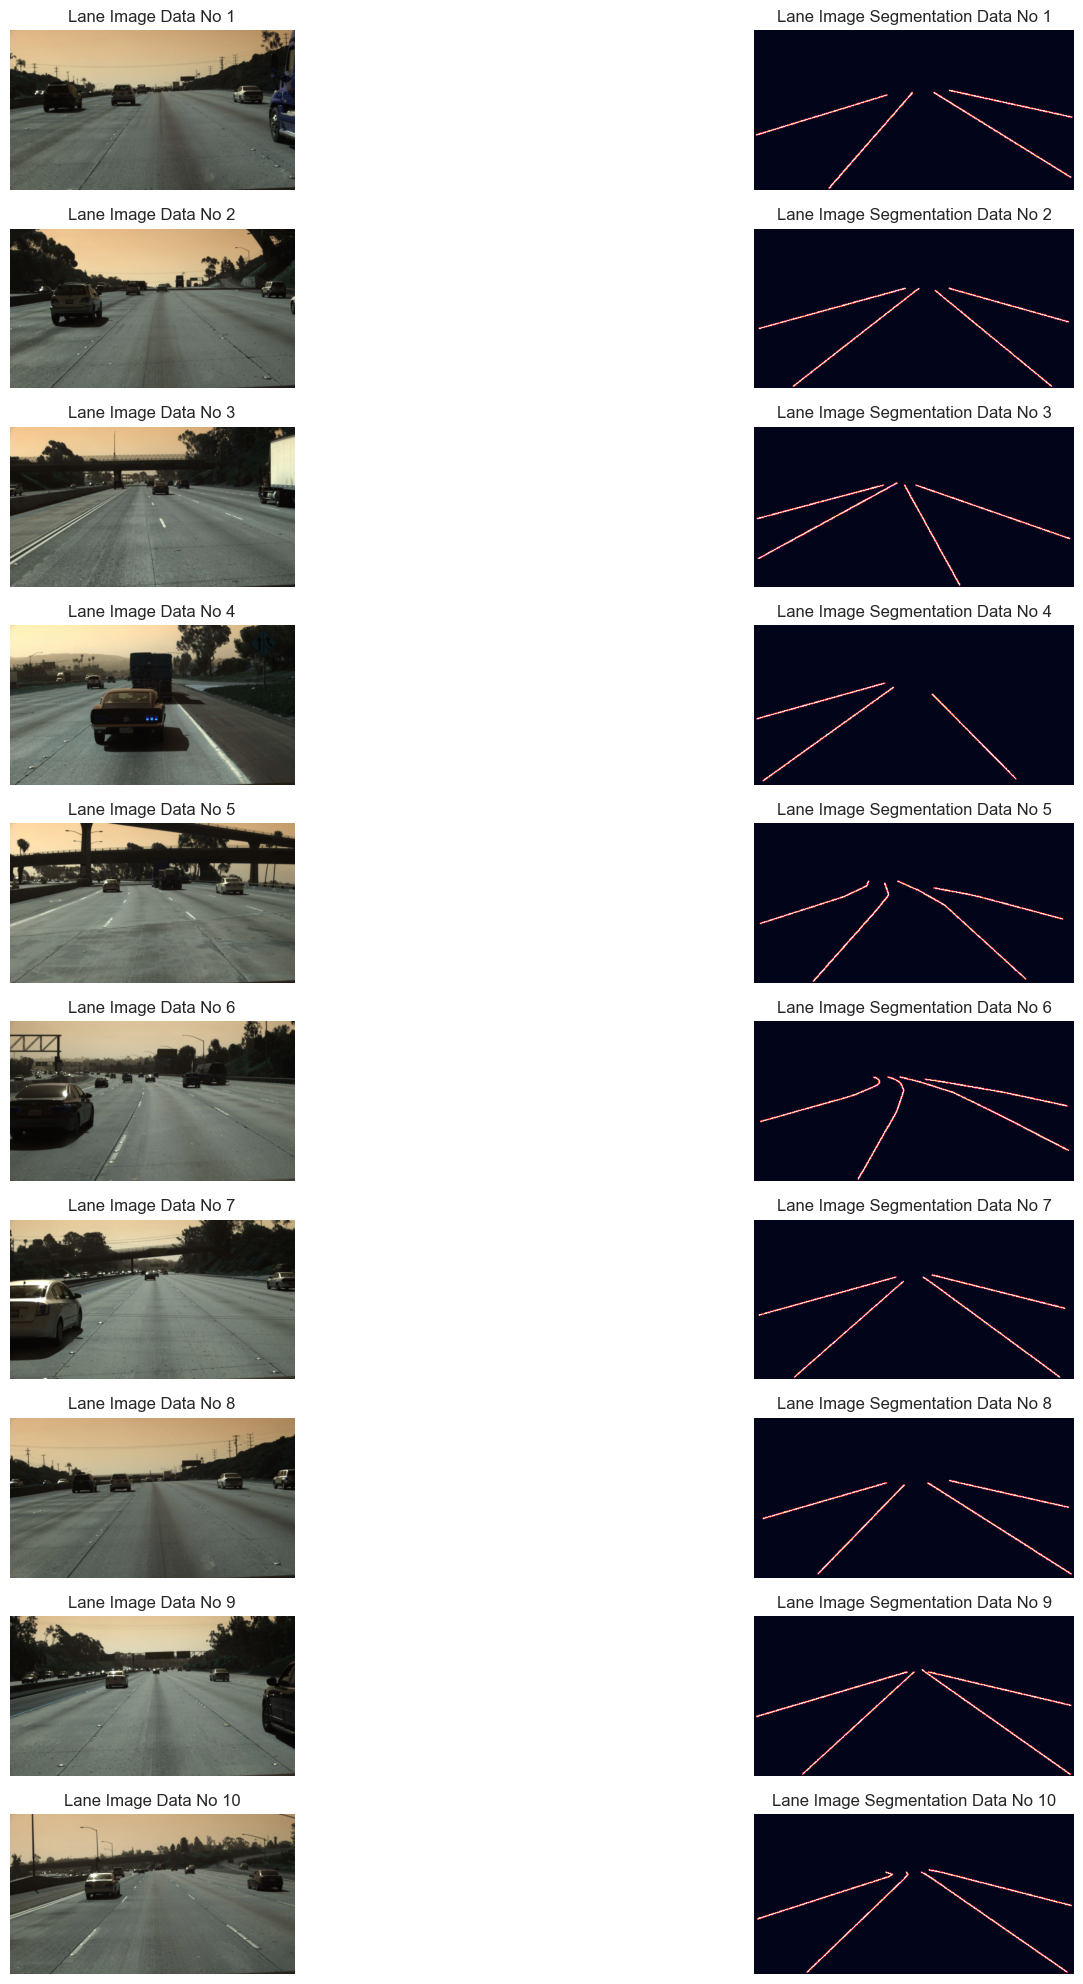

In [180]:
lane = LaneDataset()
lane._show_images(10)
